# Stock data: Time-series vs. NLP

Just recenly talk with my friend on Whatsapp. He ask me about classification on time series data. At first I was confused about "classification on time series data". I thought that time series is just time series right? You do time series with time series model like ARIMA (that's the only model that I know). What do you mean by classification? And then I remember that actually I've seen the same problem on [Kaggle](https://www.kaggle.com/aaron7sun/stocknews). The problem of of the time series data is transformed into classication problem: the goal is to predict whether the today open index would be lower or higher than the today closing index. What is the predictor then? The predictor variables is news headlines from Reddit!

It's a binary classification problem with quite balanced target. But can we actually be able to predict the market with headline news? I heard that some financial institution and hedge fund actually use the news as one of their variables.

In this notebook, I want to try it. It is a good resource to learn more about time series and NLP classification problem. So let's go, starts with data description:

__Description:__

There are two channels of data provided in the dataset by the data contributor
1. News data: He crawled historical news headline from Reddit WorldNews Channel. They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date. (Range: 2008-06-08 to 2016-07-01)
2. Stock data: Dow Jones Industrial Average (DJIA) is used to "prove the concept". (Range: 2008-08-08 to 2016-07-01)

He provided three data files in .csv format:
1. __RedditNews.csv__: two columns, the first column is the "date", and the second column is the "news headlines". All the news are ranked from top to bottom based on how hot they are. Hence, there are 25 lines for each date.
2. __DJIA_table.csv__: Downloaded direcly from [Yahoo Finance](https://finance.yahoo.com/quote/%5EDJI/history?p=%5EDJI)
3. __Combined_News_DJIA.csv__: Combined 27 columns: The first column is date, the second is the label () and the rest is the top1 to top25 news headlines.

One note from data contributor:
> If you think you coded an amazing trading algorithm, friendly advice, do play safe with your own money :)

Since the data is small, I provided in this github too, you can look at it in `notebooks/data/stocknews`

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from fbprophet import Prophet

%matplotlib inline

In [2]:
djia = pd.read_csv('./data/stocknews/DJIA_table.csv')
djia.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [3]:
djia.shape

(1989, 7)

In [4]:
djia['Date'] = pd.to_datetime(djia['Date'], format="%Y-%m-%d")
djia_oc = djia[['Date', 'Open', 'Close']].set_index('Date')
djia_oc.head()

,Open,Close
Date,,
2016-07-01,17924.240234,17949.369141
2016-06-30,17712.759766,17929.990234
2016-06-29,17456.019531,17694.679688
2016-06-28,17190.509766,17409.720703
2016-06-27,17355.210938,17140.240234


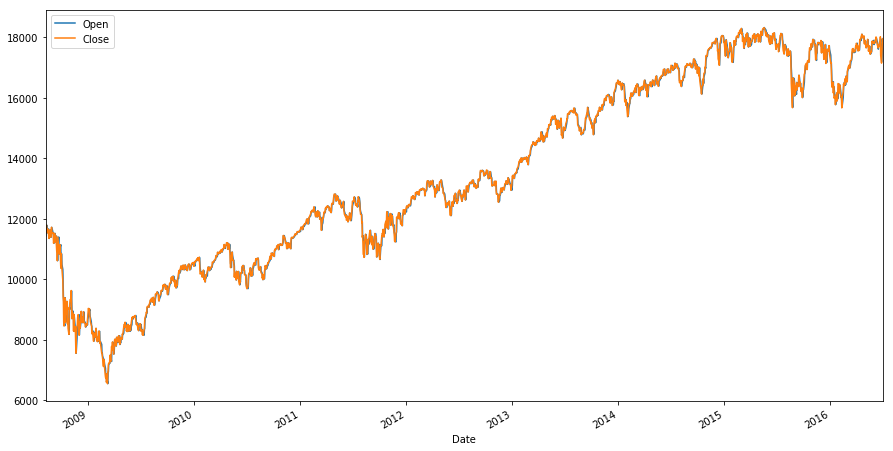

In [5]:
djia_oc.plot(figsize=(15,8))

A little bit intermeso, what is djia value actually? If you have ever play with sp500, this looks just the same.

Since it's about 7 years of daily data (about 2000 rows), we cannot see clearly how it's behave in daily basis. So let's plot a small range (30 days) data, staring from 2012-07-02.

In [6]:
start = pd.to_datetime('2012-07-02', format='%Y-%m-%d')
end = start + timedelta(days=30)
start

Timestamp('2012-07-02 00:00:00')

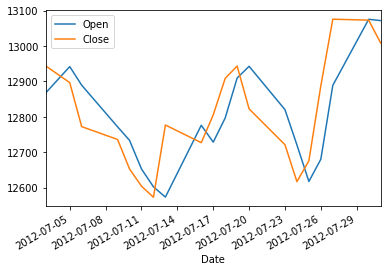

In [7]:
djia_oc[(djia_oc.index > start) & (djia_oc.index < end)].plot()

What a great sample for illustration. We can see that when the trends is going down, the close is lower than the open. When the trends is going up, the closing value is usually higher. But the most important thing is that how it seems have a simple pattern: that the trends continue to keep going down for several days and happen the same for up trends. It seems not completely random. If you have ever study about markov process/chain or hidden markov model, this situation is quite the same: the probability of transition from up to up is higher that to down, and vice versa. To illustrate, if we give label of up to be 1 and down to be 0, the sequence of the above data would be like 11100000011111100000 something like that. But anyway, I've ever play with markov process and HMM before, but for never did that on time series data. Time series data like stock market might have some trends, and for now I don't know how to combine markov process and data with trends. So I'll leave it here for now.

## Reddit News

The second data is the Reddit news headlines. Let's see 

In [57]:
news = pd.read_csv('./data/stocknews/RedditNews.csv')
news['Date'] = pd.to_datetime(news['Date'], format='%Y-%m-%d')
news.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


Well, It just some usual news headlines.

In [58]:
news['News'].iloc[0]

'A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898.'

In [59]:
news['News'].iloc[2]

'The president of France says if Brexit won, so can Donald Trump'

I don't have experince about how some event in the world can affect the stock prices. For example the news about 117-year-old woman, nobody would think that would affect the market. Some news related to finance or politics might affect the market. So I think it is not a best practice to include all the news into consideration. 

If only we can classify the news according to it's topic and then do a sentiment analysis to the market. But that's the point isn't it? We can reverse the problem for training: determine a set of word feature maybe, like whether there are words like "crisis" in the list of headlines.

But it's worth to explore, so here's the plan: Well, I dont' have a plan. Well I have but I'm not really sure it will be success.

1. Using fbprophet, we can get [trend changepoints](https://facebookincubator.github.io/prophet/docs/trend_changepoints.html) of the DJIA time series. We can extract those points and then manually examine the headlines for each those points. It won't be able to do something really useful tho, but at least we can get a better picture about the data. 
- The problem whit idea no.1 is that in this around 2000 daily data, it seems like we cannot see the movement on the daily basis. We did see the up and down in the data but the range might be on several days. It might be good if we try to see the headlines first and see the word "crisis" and plot the timeline alongside the DJIA


Well, how to search the word crisis and find the datetime for that?

We can use python module for regex re

In [60]:
import re

In [61]:
def is_crisis(headline):
    if re.search('crisis', headline):
        return 1
    else:
        return 0

In [62]:
news['is_crisis'] = news['News'].map(is_crisis)

In [63]:
news.head()

,Date,News,is_crisis
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,0
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,0
2,2016-07-01,"The president of France says if Brexit won, so...",0
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...,0
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,0


In [64]:
news[news['is_crisis'] == 1]

,Date,News,is_crisis
24,2016-07-01,Ozone layer hole seems to be healing - US &amp...,1
282,2016-06-20,Japan's dementia crisis hits record levels as ...,1
431,2016-06-14,Leaked secret audio recordings of Brazils most...,1
796,2016-05-31,Migrant crisis is fueling sex trafficking of N...,1
842,2016-05-29,Lufthansa suspends flights to Venezuela amid t...,1
851,2016-05-28,Zika crisis: Rio Olympics 'should be moved or ...,1
864,2016-05-28,Brazil 'mass rape' video: President calls cris...,1
875,2016-05-27,Thailand has shut down 10 popular diving sites...,1
999,2016-05-23,"Across Africa, the worst food crisis since 198...",1
1032,2016-05-21,'We are like a bomb': food riots show Venezuel...,1


There are 647 headlines with word "crisis" in it out of 2000 times 25 number of headlines. And from a glimpse throug the headlines article that contains the word crisis above, we can see that the word crisis does always means a financial crisis. But anyway let's try it first

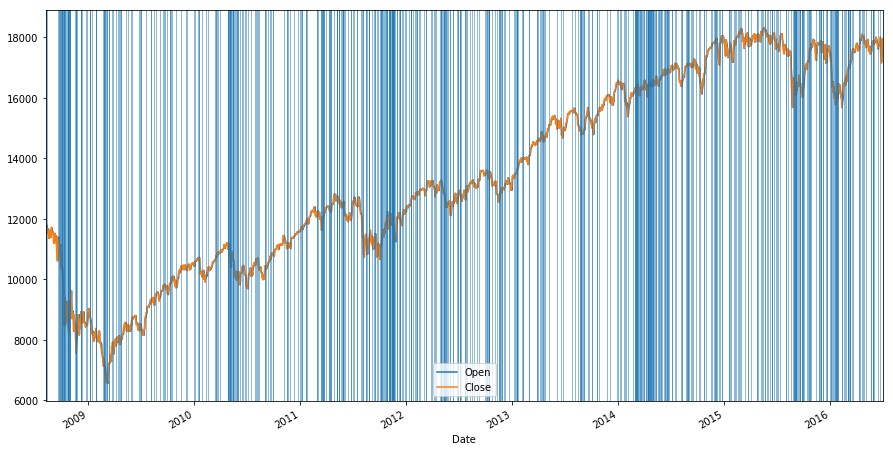

In [67]:
figure = djia_oc.plot(figsize=(15,8))
for date in news['Date'][news['is_crisis'] == 1]:
    plt.axvline(date, lw=1, alpha=0.5)

Well some headlines with word "crisis" did appears but still doesn't show a clear insight if we're to make a conclusion about the word "crisis" with market price.

In [70]:
def is_word(headline, word):
    if re.search(word, headline):
        return 1
    else:
        return 0

def plot_word(word):
    
    dates = []
    for i in news.index:
        if is_word(news['News'][i], word):
            dates.append(news['Date'][i])
    #plot
    figure = djia_oc.plot(figsize=(15,8))
    for date in dates:
        plt.axvline(date, lw=1, alpha=0.5)

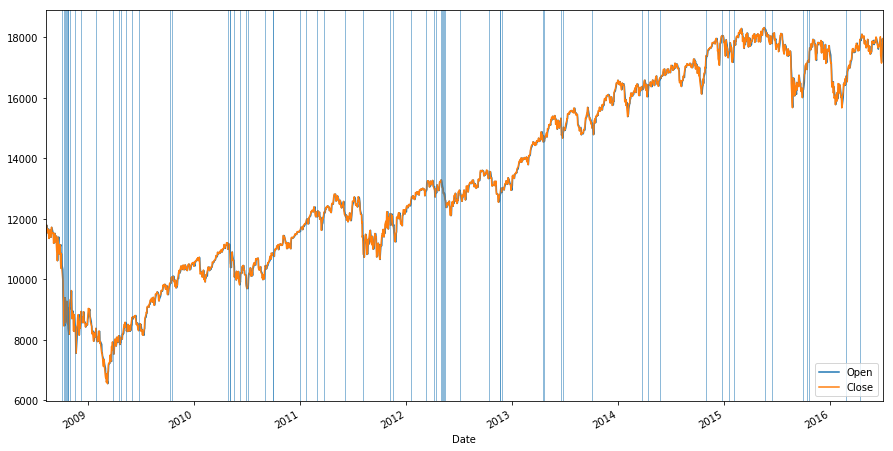

In [73]:
plot_word('financial crisis')

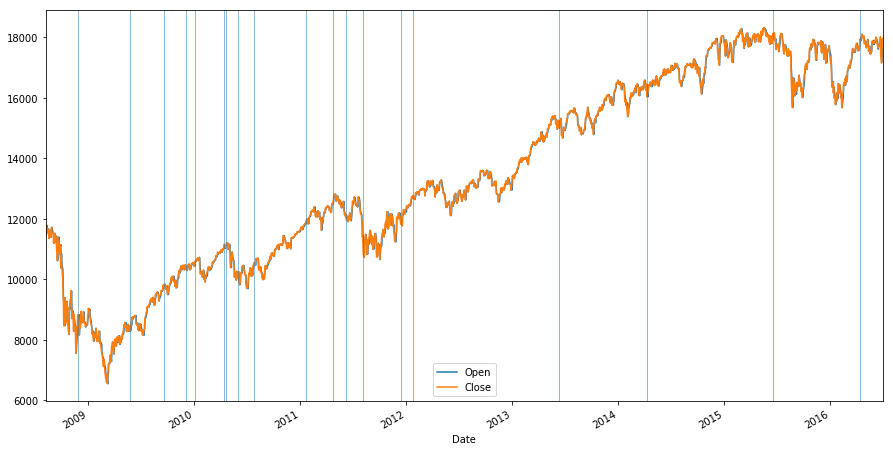

In [74]:
plot_word('bubble')

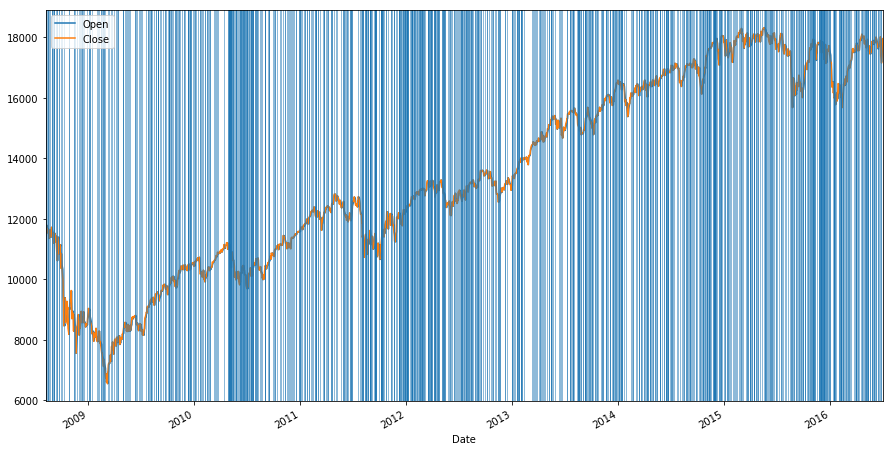

In [80]:
plot_word('oil')

Cannot do anything with this tho.

If we're going to use all the words in the news as features (with the )